<a href="https://colab.research.google.com/github/318281029SBH/Escuela/blob/main/JobLeft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Funciones y libbrerias

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [ ]:
def freq(df, var):

    if type(var) != list:
        var = [var]
    for v in var:
        #v = 'state'
        aux = df[v].value_counts().to_frame().rename(columns={'count':'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply(  np.cumsum )
        print(f"La variable: {v}")
        display(aux)
        print("\n")

In [ ]:
def normalizar(df, v, umbral):
    #umbral = 0.03 # 0.05
    aux = df[v].value_counts(normalize=True).to_frame() #aux es un df con la FA
    aux[f"n_{v}"] = np.where( aux['proportion'] < umbral , 'otros' ,aux.index ) #agregan columna para indicar si la clase es peque;a (debajo umbral)

    #moda  = aux[f'n_{v}'].values[0] #la moda es la clase m[as] repetida
    #moda=aux.loc[ aux[f'n_{v}'] == 'otros'].values[0]

    #if aux.loc[ aux[f'n_{v}'] == 'CAT_PEQUE']: #se toman las categorias peque;as y si su suma en proporci[on es menor al umbral,
     #   aux[f'n_{v}'].replace({'CAT_PEQUE':'otros'},inplace=True) # deja de ser cat peque;a y pasa a ser la moda

    aux.reset_index(inplace=True) #para que el indice pase a ser un atributo m[a]s

    return df.merge( aux , left_on=[v] , right_on=[v] , how='inner' ).drop('proportion',axis=1)

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
def discretizar_2(df_aux, v, k):

    kb = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile', subsample=None)
    df_aux = df_aux.copy()

    # Asegurar que no haya valores NaN antes de discretizar
    df_aux[v] = pd.to_numeric(df_aux[v], errors='coerce')
    df_aux = df_aux.dropna(subset=[v])

    # Ajustar el discretizador
    kb.fit(df_aux[[v]])

    # Obtener los intervalos como strings usando pd.cut()
    bins = kb.bin_edges_[0]  # Extraer los límites de los bins
    df_aux[f'd_{v}_{k}'] = pd.cut(df_aux[v], bins=bins, include_lowest=True).astype(str)

    return df_aux

In [ ]:
def calculo_iv(df , v, tgt, um):
    #v = 'n_week_day_2'
    aux = df.pivot_table( index = v , columns=tgt, values=um, aggfunc='count', fill_value=0 )
    aux[ list(range(2)) ] = aux/aux.apply(np.sum)
    aux['w'] = np.log( aux[0] / aux[1] )
    aux['iv'] = (aux[0] - aux[1])*aux['w']

    return v, aux['iv'].sum()

## EDA

###Lectura de datos

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/dataSet/HR_dataset.csv')

In [ ]:
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [ ]:
data.head(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium


###Explorac

In [ ]:
data.isna().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
Department,0
salary,0


In [ ]:
um=['index']
tgt=['left']

In [ ]:
var=[]
for v in data.columns.tolist():
  if v not in tgt:
    var.append(v)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros= RandomOverSampler(random_state=0)
X_ros,y_ros=ros.fit_resample(data[var],data[tgt])
# Combine X_ros and y_r0s into a single DataFrame
data_ros = pd.concat([X_ros, y_ros], axis=1)

In [ ]:
data_ros.shape

(22856, 10)

In [ ]:
var_cat=['Department', 'salary','Work_accident','promotion_last_5years']

In [ ]:
var_or=[]
for v in data_ros.columns.tolist():
  if v not in var_cat:
    var_or.append(v)
var_or.remove('left')

array([[<Axes: title={'center': 'satisfaction_level'}>,
        <Axes: title={'center': 'last_evaluation'}>,
        <Axes: title={'center': 'number_project'}>],
       [<Axes: title={'center': 'average_montly_hours'}>,
        <Axes: title={'center': 'time_spend_company'}>,
        <Axes: title={'center': 'Work_accident'}>],
       [<Axes: title={'center': 'left'}>,
        <Axes: title={'center': 'promotion_last_5years'}>, <Axes: >]],
      dtype=object)

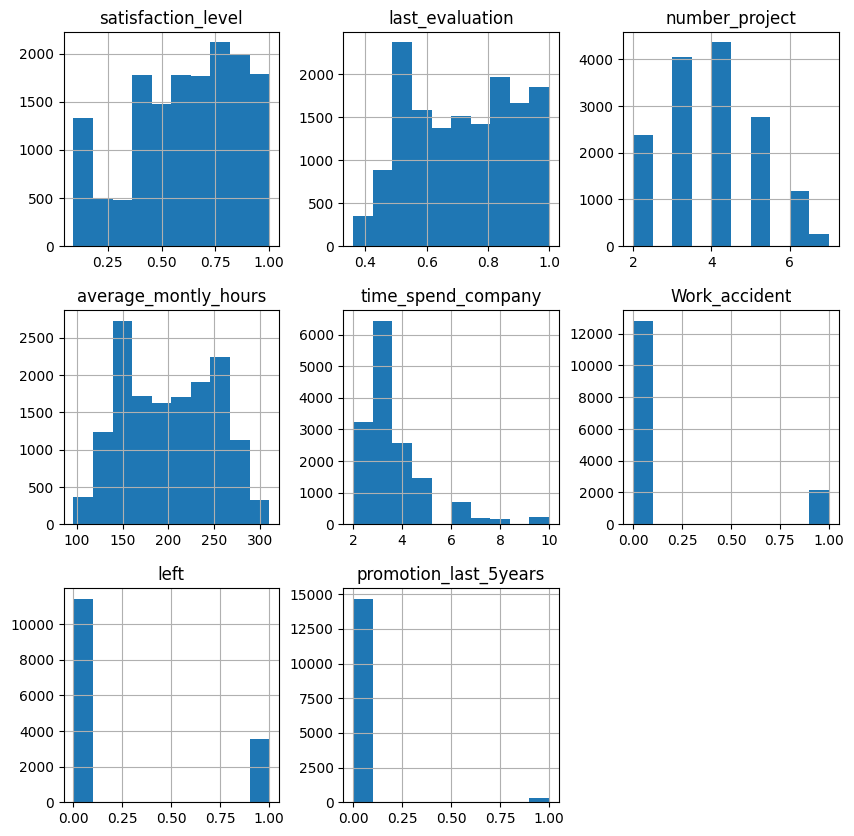

In [ ]:
data.hist(figsize=(10,10))

In [ ]:
freq(data,var_cat)

La variable: Department


,FA,FR,FAA,FRA
Department,,,,
sales,4140,0.276018,4140,0.276018
technical,2720,0.181345,6860,0.457364
support,2229,0.148610,9089,0.605974
IT,1227,0.081805,10316,0.687779
product_mng,902,0.060137,11218,0.747917
marketing,858,0.057204,12076,0.805120
RandD,787,0.052470,12863,0.857591
accounting,767,0.051137,13630,0.908727
hr,739,0.049270,14369,0.957997




La variable: salary


,FA,FR,FAA,FRA
salary,,,,
low,7316,0.487766,7316,0.487766
medium,6446,0.429762,13762,0.917528
high,1237,0.082472,14999,1.000000




La variable: Work_accident


,FA,FR,FAA,FRA
Work_accident,,,,
0,12830,0.85539,12830,0.85539
1,2169,0.14461,14999,1.00000




La variable: promotion_last_5years


,FA,FR,FAA,FRA
promotion_last_5years,,,,
0,14680,0.978732,14680,0.978732
1,319,0.021268,14999,1.000000


##Variables Nmericas-ordinales

In [ ]:
for v in var_or:
    for k in range(2, 4):
        # cuando k es mayor al número de valores únicos
        if data_ros[v].nunique() < k:
            print(f"Saltando {v} con {k} bins porque tiene pocos valores únicos.")
            continue
        print(f"Para la variable {v}, con {k} bins.")
        #df = discretizar(df, v, k)
        data_ros = discretizar_2(data_ros, v, k)

Para la variable satisfaction_level, con 2 bins.
Para la variable satisfaction_level, con 3 bins.
Para la variable last_evaluation, con 2 bins.
Para la variable last_evaluation, con 3 bins.
Para la variable number_project, con 2 bins.
Para la variable number_project, con 3 bins.
Para la variable average_montly_hours, con 2 bins.
Para la variable average_montly_hours, con 3 bins.
Para la variable time_spend_company, con 2 bins.
Para la variable time_spend_company, con 3 bins.


In [ ]:
data_ros.head(2)

,index,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Department,salary,...,d_satisfaction_level_2,d_satisfaction_level_3,d_last_evaluation_2,d_last_evaluation_3,d_number_project_2,d_number_project_3,d_average_montly_hours_2,d_average_montly_hours_3,d_time_spend_company_2,d_time_spend_company_3
0,0,0.38,0.53,2,157,3,0,0,sales,low,...,"(0.089, 0.56]","(0.089, 0.42]","(0.359, 0.73]","(0.359, 0.57]","(1.999, 4.0]","(1.999, 3.0]","(95.999, 204.0]","(95.999, 160.0]","(1.999, 3.0]","(1.999, 3.0]"
1,1,0.80,0.86,5,262,6,0,0,sales,medium,...,"(0.56, 1.0]","(0.73, 1.0]","(0.73, 1.0]","(0.84, 1.0]","(4.0, 7.0]","(4.0, 7.0]","(204.0, 310.0]","(240.0, 310.0]","(3.0, 10.0]","(4.0, 10.0]"


In [ ]:
data_ros.reset_index(inplace=True)

In [ ]:
freq(data_ros.filter(like='d_'),data_ros.filter(like='d_').columns.tolist())

La variable: time_spend_company


,FA,FR,FAA,FRA
time_spend_company,,,,
3,9932,0.434547,9932,0.434547
4,4477,0.195879,14409,0.630425
2,3363,0.147139,17772,0.777564
5,3308,0.144732,21080,0.922296
6,1212,0.053028,22292,0.975324
10,214,0.009363,22506,0.984687
7,188,0.008225,22694,0.992912
8,162,0.007088,22856,1.000000




La variable: d_satisfaction_level_2


,FA,FR,FAA,FRA
d_satisfaction_level_2,,,,
"(0.089, 0.56]",11559,0.505732,11559,0.505732
"(0.56, 1.0]",11297,0.494268,22856,1.000000




La variable: d_satisfaction_level_3


,FA,FR,FAA,FRA
d_satisfaction_level_3,,,,
"(0.089, 0.42]",7769,0.339911,7769,0.339911
"(0.42, 0.73]",7553,0.330460,15322,0.670371
"(0.73, 1.0]",7534,0.329629,22856,1.000000




La variable: d_last_evaluation_2


,FA,FR,FAA,FRA
d_last_evaluation_2,,,,
"(0.359, 0.73]",11495,0.502931,11495,0.502931
"(0.73, 1.0]",11361,0.497069,22856,1.000000




La variable: d_last_evaluation_3


,FA,FR,FAA,FRA
d_last_evaluation_3,,,,
"(0.359, 0.57]",7758,0.339429,7758,0.339429
"(0.84, 1.0]",7565,0.330985,15323,0.670415
"(0.57, 0.84]",7533,0.329585,22856,1.000000




La variable: d_number_project_2


,FA,FR,FAA,FRA
d_number_project_2,,,,
"(1.999, 4.0]",15315,0.670065,15315,0.670065
"(4.0, 7.0]",7541,0.329935,22856,1.000000




La variable: d_number_project_3


,FA,FR,FAA,FRA
d_number_project_3,,,,
"(1.999, 3.0]",10060,0.440147,10060,0.440147
"(4.0, 7.0]",7541,0.329935,17601,0.770082
"(3.0, 4.0]",5255,0.229918,22856,1.000000




La variable: d_average_montly_hours_2


,FA,FR,FAA,FRA
d_average_montly_hours_2,,,,
"(95.999, 204.0]",11483,0.502406,11483,0.502406
"(204.0, 310.0]",11373,0.497594,22856,1.000000




La variable: d_average_montly_hours_3


,FA,FR,FAA,FRA
d_average_montly_hours_3,,,,
"(95.999, 160.0]",7820,0.342142,7820,0.342142
"(160.0, 240.0]",7539,0.329848,15359,0.671990
"(240.0, 310.0]",7497,0.328010,22856,1.000000




La variable: d_time_spend_company_2


,FA,FR,FAA,FRA
d_time_spend_company_2,,,,
"(1.999, 3.0]",13295,0.581685,13295,0.581685
"(3.0, 10.0]",9561,0.418315,22856,1.000000




La variable: d_time_spend_company_3


,FA,FR,FAA,FRA
d_time_spend_company_3,,,,
"(1.999, 3.0]",13295,0.581685,13295,0.581685
"(4.0, 10.0]",5084,0.222436,18379,0.804121
"(3.0, 4.0]",4477,0.195879,22856,1.000000


In [ ]:
X = data[um+var_or]
y = data[um + tgt]

KeyError: "['index'] not in index"

In [ ]:
df = pd.DataFrame({'bar': [1, 2, 2, 2, 2, 2],
                   'baz': [1, 2, 3, 4, 5, 6]})

In [ ]:
list(range(2))

[0, 1]

In [ ]:
df.apply(np.sum)

,0
bar,11
baz,21


In [ ]:
df[list(range(2))]=df.apply(np.sum)

/tmp/ipython-input-1034961134.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[list(range(2))]=df.apply(np.sum)
/tmp/ipython-input-1034961134.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[list(range(2))]=df.apply(np.sum)


In [ ]:
df

,bar,baz,0,1
0,1,1,11,21
1,2,2,11,21
2,2,3,11,21
3,2,4,11,21
4,2,5,11,21
5,2,6,11,21


In [ ]:
vari=data_ros.filter(like='d_').columns.tolist()

In [ ]:
vari

['time_spend_company',
 'd_satisfaction_level_2',
 'd_satisfaction_level_3',
 'd_last_evaluation_2',
 'd_last_evaluation_3',
 'd_number_project_2',
 'd_number_project_3',
 'd_average_montly_hours_2',
 'd_average_montly_hours_3',
 'd_time_spend_company_2',
 'd_time_spend_company_3']

In [ ]:
vari.remove('time_spend_company')

In [ ]:
v='d_average_montly_hours_2'

In [ ]:
calculo_iv(data, v, tgt, um)

('d_average_montly_hours_2', np.float64(0.009909621653027206))

In [ ]:
data_ros['left']

##FeatureSelection

Class imbalance could affect th iv values since could affect the disitribution probability of the classes a long the bins

In [ ]:
def calculo_iv(df , v, tgt, um):
    #v = 'n_week_day_2'
    aux = df.pivot_table( index = v , columns=tgt, values=um, aggfunc='count', fill_value=0 )
    aux[ list(range(2)) ] = aux/aux.apply(np.sum)
    aux['w'] = np.log( aux[0] / aux[1] )
    aux['iv'] = (aux[0] - aux[1])*aux['w']

    return v, aux['iv'].sum()

###Categories

In [ ]:
iv2  = pd.DataFrame( map( lambda v: calculo_iv(data_ros, v, tgt, um) , var_cat ) , columns=['variable','IV'] ).sort_values('IV',ascending=False)
iv2

,variable,IV
1,salary,0.190794
2,Work_accident,0.162798
0,Department,0.039642
3,promotion_last_5years,0.035255


In [ ]:
best2=iv2.loc[iv2['IV']>0.1]
'''best_cat=[]
for v in var_cat:
  best_cat.append(iv2[iv2['variable'].str.contains(v)].sort_values('IV',ascending=False)['variable'].values[0])
best_cat'''

"best_cat=[]\nfor v in var_cat:\n  best_cat.append(iv2[iv2['variable'].str.contains(v)].sort_values('IV',ascending=False)['variable'].values[0])\nbest_cat"

In [ ]:
best3=list(best2['variable'])
best3

['salary', 'Work_accident']

###Numeric/continuos

In [ ]:
aux = data.pivot_table( index = v , columns=tgt, values=um, aggfunc='count', fill_value=0 )

KeyError: 'index'

In [ ]:
aux

index      
left                         0     1
d_average_montly_hours_2            
(200.0, 310.0]            5560  1915
(95.999, 200.0]           5868  1656

In [ ]:
### IV para las variables discretizadas:
iv  = pd.DataFrame( map( lambda v: calculo_iv(data_ros, v, tgt, um) , vari) , columns=['variable','IV'] ).sort_values('IV',ascending=False)
iv

In [ ]:
best=iv.loc[iv['IV']>0.1]
best_var=[]
for v in var_or:
  best_var.append(best[best['variable'].str.contains(v)].sort_values('IV',ascending=False)['variable'].values[0])
best_var

In [ ]:
data_ros[best3+best_var]

,salary,Work_accident,d_satisfaction_level_3,d_last_evaluation_3,d_number_project_3,d_average_montly_hours_3,d_time_spend_company_3
0,low,0,"(0.089, 0.42]","(0.359, 0.57]","(1.999, 3.0]","(95.999, 160.0]","(1.999, 3.0]"
1,medium,0,"(0.73, 1.0]","(0.84, 1.0]","(4.0, 7.0]","(240.0, 310.0]","(4.0, 10.0]"
2,medium,0,"(0.089, 0.42]","(0.84, 1.0]","(4.0, 7.0]","(240.0, 310.0]","(3.0, 4.0]"
3,low,0,"(0.42, 0.73]","(0.84, 1.0]","(4.0, 7.0]","(160.0, 240.0]","(4.0, 10.0]"
4,low,0,"(0.089, 0.42]","(0.359, 0.57]","(1.999, 3.0]","(95.999, 160.0]","(1.999, 3.0]"
...,...,...,...,...,...,...,...
22851,low,0,"(0.089, 0.42]","(0.359, 0.57]","(1.999, 3.0]","(95.999, 160.0]","(1.999, 3.0]"
22852,high,0,"(0.42, 0.73]","(0.359, 0.57]","(1.999, 3.0]","(95.999, 160.0]","(1.999, 3.0]"
22853,low,0,"(0.089, 0.42]","(0.359, 0.57]","(1.999, 3.0]","(95.999, 160.0]","(1.999, 3.0]"
22854,low,0,"(0.089, 0.42]","(0.57, 0.84]","(4.0, 7.0]","(240.0, 310.0]","(3.0, 4.0]"


In [ ]:
best_var2=best3+best_var

##WOE MAP



*   Weight of evidence. the weight in favor of the hypotesis h, provided by evidence e.
*   Is a proportion betwen the prior and posterior odds. We would like posterior odd.
*   We have two hypotesis true-false. the evidence are the classes. So then, we would like posterior odd would be more higher than prior.
*   in this case the the most highly values (or lower) the better till a limit in dispicte that a big contidional probability tell us that the evidence is suffcient to know the true value of hypotesis and it means almost all data  belongs a specific class







In [ ]:
def clasificacion_woe(df , v, tgt, um):
    #v = 'n_week_day_2'
    aux = df.pivot_table( index = v ,
                          columns=tgt,
                         values=um,
                         aggfunc='count',
                         fill_value=0 )

    aux[ list(range(2)) ] = aux/aux.apply(np.sum)

    aux['w'] = np.log( aux[0] / aux[1] )

    aux.drop(range(2),axis=1,inplace=True)

    #aux = aux.to_dict()['w']
    aux = aux['w'].to_dict()



    return v, aux

In [ ]:
X = data_ros[um + best_var2]
y = data_ros[um + tgt ]
Xt, Xv , yt , yv = train_test_split(X, y, train_size=.7)


In [ ]:
best_var2

['salary',
 'Work_accident',
 'd_satisfaction_level_3',
 'd_last_evaluation_3',
 'd_number_project_3',
 'd_average_montly_hours_3',
 'd_time_spend_company_3']

In [ ]:
Xt2 = Xt.merge(yt, on=um, how='inner').reset_index(drop=True)

In [ ]:
Xt2.drop('index',axis=1,inplace=True)

In [ ]:
Xt2.reset_index(inplace=True)

In [ ]:
mapa_woe = list( map( lambda v: clasificacion_woe( Xt2 , v , tgt , um) , best_var2 ))

In [ ]:
mapa_woe

[('salary',
  {'high': 1.696801434297715,
   'low': -0.3137976463576882,
   'medium': 0.199691609413857}),
 ('Work_accident', {0: -0.1337063817225972, 1: 1.1869485562558282}),
 ('d_satisfaction_level_3',
  {'(0.089, 0.42]': -1.429455250145967,
   '(0.42, 0.73]': 0.7594813880071065,
   '(0.73, 1.0]': 0.5516468620173105}),
 ('d_last_evaluation_3',
  {'(0.359, 0.57]': -0.6354882864174709,
   '(0.57, 0.84]': 1.1542592667515312,
   '(0.84, 1.0]': -0.4213502244611564}),
 ('d_number_project_3',
  {'(1.999, 3.0]': -0.09983214468541395,
   '(3.0, 4.0]': 1.1101784980625256,
   '(4.0, 7.0]': -0.5934352914014022}),
 ('d_average_montly_hours_3',
  {'(160.0, 240.0]': 1.3049635004979088,
   '(240.0, 310.0]': -0.5797968497903395,
   '(95.999, 160.0]': -0.5624747865147277}),
 ('d_time_spend_company_3',
  {'(1.999, 3.0]': 0.42680377608237924,
   '(3.0, 4.0]': -0.5199834202860052,
   '(4.0, 10.0]': -0.6720214434177064})]

In [ ]:

display(data_ros.head())

,index,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Department,salary,...,d_satisfaction_level_3,d_last_evaluation_2,d_last_evaluation_3,d_number_project_2,d_number_project_3,d_average_montly_hours_2,d_average_montly_hours_3,d_time_spend_company_2,d_time_spend_company_3,left
0,0,0.38,0.53,2,157,3,0,0,sales,low,...,"(0.089, 0.52]","(0.359, 0.72]","(0.359, 0.61]","(1.999, 4.0]","(1.999, 3.0]","(95.999, 200.0]","(95.999, 168.0]","(1.999, 3.0]","(1.999, 3.0]",1
1,1,0.80,0.86,5,262,6,0,0,sales,medium,...,"(0.76, 1.0]","(0.72, 1.0]","(0.82, 1.0]","(4.0, 7.0]","(4.0, 7.0]","(200.0, 310.0]","(232.0, 310.0]","(3.0, 10.0]","(4.0, 10.0]",1
2,2,0.11,0.88,7,272,4,0,0,sales,medium,...,"(0.089, 0.52]","(0.72, 1.0]","(0.82, 1.0]","(4.0, 7.0]","(4.0, 7.0]","(200.0, 310.0]","(232.0, 310.0]","(3.0, 10.0]","(3.0, 4.0]",1
3,3,0.72,0.87,5,223,5,0,0,sales,low,...,"(0.52, 0.76]","(0.72, 1.0]","(0.82, 1.0]","(4.0, 7.0]","(4.0, 7.0]","(200.0, 310.0]","(168.0, 232.0]","(3.0, 10.0]","(4.0, 10.0]",1
4,4,0.37,0.52,2,159,3,0,0,sales,low,...,"(0.089, 0.52]","(0.359, 0.72]","(0.359, 0.61]","(1.999, 4.0]","(1.999, 3.0]","(95.999, 200.0]","(95.999, 168.0]","(1.999, 3.0]","(1.999, 3.0]",1


In [ ]:
freq(data_ros,'left')

La variable: left


,FA,FR,FAA,FRA
left,,,,
1,11428,0.5,11428,0.5
0,11428,0.5,22856,1.0


In [ ]:
data.shape

(14999, 21)

In [ ]:
var

['index',
 'satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years',
 'Department',
 'salary',
 'd_satisfaction_level_2',
 'd_satisfaction_level_3',
 'd_last_evaluation_2',
 'd_last_evaluation_3',
 'd_number_project_2',
 'd_number_project_3',
 'd_average_montly_hours_2',
 'd_average_montly_hours_3',
 'd_time_spend_company_2',
 'd_time_spend_company_3']

(['d_satisfaction_level_3',
  'd_last_evaluation_3',
  'd_number_project_3',
  'd_average_montly_hours_3',
  'd_time_spend_company_3'],
         variable        IV
 1         salary  0.190794
 2  Work_accident  0.162798)